Modern software development includes a plethora of tools and frameworks, such as build tools, code frameworks, CI/CD pipelines, containerization technologies, and platforms. These tools and frameworks typically have their own configuration files in which hundreds of configuration options are defined. The **configurability of technologies** is a double-edged sword. On the one hand, it allows developers to customize the behavior of tools and frameworks to suit their specific needs. On the other hand, it can lead to complexity and confusion, especially when there are many options to choose from or when the options are poorly documented. We will explore the configurability of technologies by approximating the configuration space of a technology and analyzing the configuration options. This way, we explore how many options a technology provides and how many of those options are actually used in practice, answering the following research questions: How well the configuration space of a techhnology adapted to the developer (too many knobs)?

In [1]:
import glob 
import pandas as pd

def extract_options_per_technolgy():
    option_files = glob.glob("../data/options/*_options_internal.csv")

    results_dfs = []

    for file_name in option_files:
        df = pd.read_csv(file_name)

        results_dfs.append(df)

    df_all = pd.concat(results_dfs, ignore_index=True)

    df_technologies = (
        df_all.groupby('Concept')
        .apply(lambda x: x[['Option']].drop_duplicates().reset_index(drop=True))
        .reset_index()
        .drop(columns=['level_1'])
    )

    technologies = df_technologies['Concept'].unique()

    for technology in technologies:
        df_technology = df_technologies[df_technologies['Concept'] == technology]
        df_technology.to_csv(f"../data/technology/{technology}_options.csv", index=False)


extract_options_per_technolgy()

/tmp/ipykernel_430501/2875671594.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[['Option']].drop_duplicates().reset_index(drop=True))


*How many configuration options does a technology provide?*

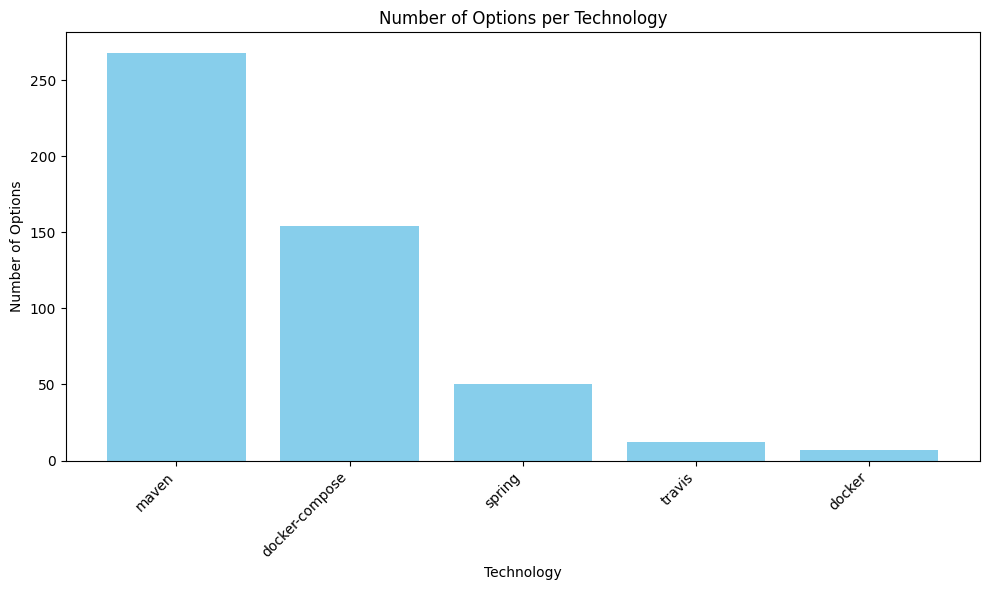

,Technology,Number Options
3,maven,268
2,docker-compose,154
4,spring,50
0,travis,12
1,docker,7


In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

def show_options_per_technology():
    technology_files = glob.glob("../data/technology/*_options.csv")

    num_options = []

    common_file_types = ["json", "yaml", "configparser"]

    for file_name in technology_files:
        technology = file_name.split("/")[-1].split("_")[0]
        if technology in common_file_types:
            continue
        df = pd.read_csv(file_name)
        num_options.append((technology, len(df)))

    # Create a bar chart
    df_num_options = pd.DataFrame(num_options, columns=['Technology', 'Number Options'])
    df_num_options.sort_values(by='Number Options', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    plt.bar(df_num_options['Technology'], df_num_options['Number Options'], color='skyblue')
    plt.xlabel('Technology')
    plt.ylabel('Number of Options')
    plt.title('Number of Options per Technology')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return df_num_options

df_options = show_options_per_technology()
df_options

*How many options are actually set in software project of a specific technology?*

In [2]:
import pandas as pd
import glob


project_file = "../data/options/piggymetrics_options_internal.csv"
df_project = pd.read_csv(project_file)

technology_file = "../data/technology/docker_options.csv"
df_technology = pd.read_csv(technology_file)


# Normalize option names for comparison (e.g., uppercase, strip whitespace)
technology_options_set = set(df_technology["Option"].str.strip().str.upper())
project_options_set = set(df_project["Option"].str.strip().str.upper())

# Find intersection
matched_options = technology_options_set & project_options_set

# Result summary
matched_count = len(matched_options)
total_docker_options = len(technology_options_set)
percentage_matched = round((matched_count / total_docker_options) * 100, 2)

{
    "Total Docker Options": total_docker_options,
    "Matched in Project": matched_count,
    "Percentage Used": f"{percentage_matched}%",
    "Matched Options (Preview)": list(matched_options)[:10]
}




{'Total Docker Options': 7,
 'Matched in Project': 7,
 'Percentage Used': '100.0%',
 'Matched Options (Preview)': ['EXPOSE',
  'ADD',
  'WORKDIR',
  'FROM',
  'RUN',
  'ENTRYPOINT',
  'CMD']}

In [12]:
from pathlib import Path
import pandas as pd

def extract_matched_options(project_name: str):
    project_df = pd.read_csv(f"../data/options/{project_name}_options_internal.csv")  # or your DataFrame

    # Normalize project option names
    project_options = project_df.copy()
    project_options["Option"] = project_options["Option"].str.strip().str.upper()

    # Prepare result table
    results = []

    # Iterate over all reference files
    for ref_file in glob.glob("../data/technology/*_options.csv"):
        ref_df = pd.read_csv(ref_file)
        concept_name = ref_df["Concept"].iloc[0]  # assuming one concept per file

        # Normalize reference options
        ref_options = set(ref_df["Option"].str.strip().str.upper())
        project_subset = set(project_options[project_options["Concept"].str.lower() == concept_name.lower()]["Option"])

        matched = ref_options & project_subset
        results.append({
            "Technology": concept_name,
            "Total Options": len(ref_options),
            "Matched Options": len(matched),
            "Percentage Used": round(len(matched) / len(ref_options) * 100, 2),
            "Matched (Preview)": list(matched)[:5]
        })


    return pd.DataFrame(results)


project_name = "test-config-repo"
df_matched = extract_matched_options(project_name)
df_matched

,Technology,Total Options,Matched Options,Percentage Used,Matched (Preview)
0,yaml,90,31,34.44,"[DATABASE.HOST, MAIL.PORT, MAIL.PASSWORD, SERV..."
1,travis,12,0,0.00,[]
2,docker,7,2,28.57,"[EXPOSE, ENTRYPOINT]"
3,docker-compose,154,7,4.55,"[SERVICES.APP.PORTS.CONTAINER, SERVICES.APP.BU..."
4,maven,268,26,9.70,[PROJECT.DEPENDENCIES.DEPENDENCY.ORG.SPRINGFRA...
5,spring,50,5,10.00,"[SPRING.DATASOURCE.USERNAME, SERVER.NAME, SPRI..."
6,configparser,151,0,0.00,[]


In [8]:
from typing import List, Set
import pandas as pd
import javaproperties
import re
import glob

def parse_properties_file(file_path: str) -> set:
    with open(file_path, "r", encoding="utf-8") as f:
        props = javaproperties.load(f)
    return set(k.strip() for k in props.keys())

def get_wildcard_matches(project_options: Set[str], ref_options: Set[str]) -> Set[str]:
    regexes = [
        re.compile('^' + re.escape(option).replace(r'\*', r'[^.]+') + '$')
        for option in ref_options
    ]
    return {opt for opt in project_options if any(rx.search(opt) for rx in regexes)}

def get_options_per_project(technology_files: List, option_data: pd.DataFrame):
    project_options = option_data.copy()
    project_options["option"] = project_options["option"].str.strip()

    # Prepare result table
    results = []

    # Iterate over all reference files
    for technology_file in technology_files:
        technology = technology_file.split("/")[-1].split(".properties")[0]
        print(technology)
        ref_options = parse_properties_file(technology_file)

        project_subset = set(project_options[project_options["concept"].str.lower() == technology.lower()]["option"])
        matched = get_wildcard_matches(project_subset, ref_options)
        unmatched = project_subset - matched

        print("Unmatched", unmatched)

        results.append({
            "Technology": technology,
            "Total Options": len(ref_options),
            "Matched Options": len(matched),
            "Unmatched Options": len(unmatched),
            "Percentage Used": round(len(matched) / len(ref_options) * 100, 2) if ref_options else 0.0,
            "Matched (Preview)": list(matched)[:5]
        })


    return pd.DataFrame(results)


property_files = glob.glob("../data/technology/*.properties")
option_data = pd.read_csv("../data/options/piggymetrics_options_latest.csv")
df = get_options_per_project(property_files, option_data)
df


django
Unmatched set()
mongodb
Unmatched set()
docker-compose
Unmatched {'services.gateway.logging.options.max-file', 'services.account-service.logging.options.max-size', 'services.config.build', 'services.account-mongodb.logging.options.max-file', 'services.config.ports.host', 'services.account-mongodb.build', 'services.config.ports.container', 'services.auth-mongodb.build', 'services.config.logging.options.max-size', 'services.notification-service.build', 'services.rabbitmq.ports.container', 'services.account-mongodb.logging.options.max-size', 'services.registry.logging.options.max-size', 'services.config.logging.options.max-file', 'services.statistics-service.logging.options.max-file', 'services.statistics-mongodb.logging.options.max-file', 'services.rabbitmq.logging.options.max-file', 'services.statistics-mongodb.logging.options.max-size', 'services.turbine-stream-service.logging.options.max-file', 'services.notification-mongodb.logging.options.max-file', 'services.auth-service.log

,Technology,Total Options,Matched Options,Unmatched Options,Percentage Used,Matched (Preview)
0,django,229,0,0,0.00,[]
1,mongodb,152,0,0,0.00,[]
2,docker-compose,235,53,73,22.55,[services.turbine-stream-service.environment.C...
3,tsconfig,129,0,0,0.00,[]
4,cargo,113,0,0,0.00,[]
5,docker,18,6,0,33.33,"[CMD, RUN, FROM, EXPOSE, ADD]"
6,cypress,49,0,0,0.00,[]
7,mysql,315,0,0,0.00,[]
8,maven,362,11,73,3.04,"[project.name, project.modules.module, project..."
9,poetry,42,0,0,0.00,[]
